# 1. Importing Libraries and downloading nltk datasets

In [ ]:
import nltk
from nltk.corpus import brown
import numpy as np
from collections import Counter,defaultdict
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score,confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("universal_tagset")
nltk.download("brown")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

# 2. Data Preparation

In [ ]:
corpus = brown.tagged_sents(tagset="universal")  # corpus
tagged_words = [tup for sent in corpus for tup in sent]
words, tags = zip(*tagged_words)
words_set, tags_set = set(words), set(tags)

# 3. Defining the class HMM

In [ ]:
class HMM:
    def __init__(self, train_data, test_data):
        self.train_data = train_data
        self.test_data = test_data
        self.epsilon = 1e-10  # for preventing Numerical underflow
        self.correct_tags = []
        self.pred_tags = []
        self.pos_accuracy = {}
        self.tags_set = tags_set
        self.words_set = words_set
        self.BOLD = "\033[1m"
        self.RED = "\033[91m"
        self.GREEN = "\033[92m"
        self.YELLOW = "\033[93m"
        self.BLUE = "\033[96m"
        self.ENDC = "\033[0m"

    def viterbi_decode(self, sentence):
        n = len(sentence)
        n_tags = len(self.tags_set)
        dp = np.zeros((n, n_tags), dtype=float)
        backpointer = np.zeros((n, n_tags), dtype=int)

        # Compute word indices and log probabilities outside the loop
        word_indices = [self.words_dict.get(word,self.tags_dict.get("NOUN", 0)) for word in sentence]
        log_initial_state_probs = np.log(self.initial_state_probs + self.epsilon)
        log_transition_probs = np.log(self.transition_probs + self.epsilon)
        log_emission_probs = np.log(self.emission_probs[:, word_indices] + self.epsilon)

        # Initialization step
        dp[0, :] = log_initial_state_probs + log_emission_probs[:, 0]

        for i in range(1, n):
            for j in range(n_tags):
                max_prob = -np.inf
                max_prev_tag = None
                for k in range(n_tags):
                    prob = (
                        dp[i - 1, k]
                        + log_transition_probs[k, j]
                        + log_emission_probs[j, i]
                    )
                    if prob > max_prob:
                        max_prob = prob
                        max_prev_tag = k
                dp[i, j] = max_prob
                backpointer[i, j] = max_prev_tag

        # Termination step
        best_final_tag = np.argmax(dp[n - 1, :])

        # Backtrack to find the best tag sequence
        best_tag_sequence = [best_final_tag]
        for i in range(n - 1, 0, -1):
            prev_tag = backpointer[i, best_tag_sequence[-1]]
            best_tag_sequence.append(prev_tag)

        return list(reversed(best_tag_sequence))

    def train(self):
        n_tags = len(self.tags_set)
        n_words = len(self.words_set)

        # Create dictionaries for word and tag indices
        self.words_dict = {word: i for i, word in enumerate(self.words_set)}
        self.tags_dict = {tag: i for i, tag in enumerate(self.tags_set)}

        # Initialize transition, emission, and initial state probabilities
        self.transition_probs = np.zeros((n_tags, n_tags))
        self.emission_probs = np.zeros((n_tags, n_words))
        self.initial_state_probs = np.zeros(n_tags)

        prev_tag_idx = None
        for sentence in tqdm(self.train_data, desc="Training Sentences", ncols=100):
              # Initialize the previous tag index
            for word, tag in sentence:
                tag_idx = self.tags_dict[tag]
                word_idx = self.words_dict[word]

                # Update emission probabilities
                self.emission_probs[tag_idx, word_idx] += 1

                # Update transition probabilities
                if prev_tag_idx is not None:
                    self.transition_probs[prev_tag_idx, tag_idx] += 1
                else:
                    # Update initial state probabilities
                    self.initial_state_probs[tag_idx] += 1
                prev_tag_idx = tag_idx

        # Normalize probabilities
        self.transition_probs /= (
            self.transition_probs.sum(axis=1, keepdims=True) + self.epsilon
        )
        self.emission_probs /= (
            self.emission_probs.sum(axis=1, keepdims=True) + self.epsilon
        )
        self.initial_state_probs /= self.initial_state_probs.sum() + self.epsilon

    def evaluate(self):
        for sentence in tqdm(self.test_data, desc="Evaluating Sentences", ncols=100):
            words, true_tags = zip(*sentence)
            predicted_tags = self.viterbi_decode(words)
            # print([list(self.tags_set)[i] for i in predicted_tags])
            self.correct_tags.extend(true_tags)
            self.pred_tags.extend([list(self.tags_set)[i] for i in predicted_tags])

    def compute_metrics(self):
        self.overall_accuracy = accuracy_score(self.correct_tags, self.pred_tags)
        self.prec = precision_score(
            self.correct_tags, self.pred_tags, average=None, zero_division=1
        )
        self.rec = recall_score(self.correct_tags, self.pred_tags, average=None)
        self.f1_scores = f1_score(self.correct_tags, self.pred_tags, average=None)
        self.f05 = fbeta_score(
            self.correct_tags, self.pred_tags, beta=0.5, average="macro"
        )
        self.f1 = fbeta_score(
            self.correct_tags, self.pred_tags, beta=1, average="macro"
        )
        self.f2 = fbeta_score(
            self.correct_tags, self.pred_tags, beta=2, average="macro"
        )
        self.conf_matrix = confusion_matrix(
            self.correct_tags, self.pred_tags, normalize="true"
        )
        self.overall_precision = precision_score(
            self.correct_tags, self.pred_tags, average="macro", zero_division=1
        )
        self.overall_recall = recall_score(
            self.correct_tags, self.pred_tags, average="macro"
        )

    def predict(self, sentence):
        predicted_tags = self.viterbi_decode(sentence)

        # Convert the predicted tag indices to tag labels
        predicted_tags = [list(self.tags_set)[i] for i in predicted_tags]
        return predicted_tags

    def print_metrics(self, i):
        from IPython.display import HTML, display

        metrics_df = pd.DataFrame(
            {
                "Tag": list(self.tags_set),
                "Precision": self.prec,
                "Recall": self.rec,
                "F1": self.f1_scores,
            }
        )
        metrics_html = metrics_df.to_html(index=False, escape=False, render_links=True)
        print()
        print(self.YELLOW + "-" * 40 + self.ENDC)
        print()
        print(self.BLUE + f"Tag Wise Metrics for Fold {i}:" + self.ENDC)
        display(HTML(metrics_html))
        # print(metrics_df.to_string(index=False))

        print(self.BLUE + f"\nOverall Metrics for Fold {i}:\n" + self.ENDC)
        print(self.GREEN + "F_0.5 Score : " + self.RED + f"{self.f05:.3f}" + self.ENDC)
        print(self.GREEN + "F1 Score    : " + self.RED + f"{self.f1:.3f}" + self.ENDC)
        print(self.GREEN + "F2 Score    : " + self.RED + f"{self.f2:.3f}" + self.ENDC)
        print(
            self.GREEN
            + "Precision   : "
            + self.RED
            + f"{self.overall_precision:.3f}"
            + self.ENDC
        )
        print(
            self.GREEN
            + "Recall      : "
            + self.RED
            + f"{self.overall_recall:.3f}"
            + self.ENDC
        )
        print()

        # print("\nPer POS Accuracy:")
        # for tag, accuracy in self.pos_accuracy.items():
        #     print(f"{tag}: {accuracy:.3f}")

        plt.figure(figsize=(12, 8))
        sns.heatmap(
            self.conf_matrix,
            annot=True,
            fmt=".2f",
            cmap="Blues",
            xticklabels=self.tags_set,
            yticklabels=self.tags_set,
        )
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"Confusion Matrix, Fold {i}")
        plt.show()

## Printing Overall Metrics Implementation

In [ ]:
BOLD = "\033[1m"
RED = "\033[91m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
BLUE = "\033[96m"
ENDC = "\033[0m"
def print_overall_metrics(f05_score_sum,f1_score_sum,f2_score_sum,precision_sum,recall_sum,fold):
    print(BOLD + BLUE + "\nAverage Metrics for all folds: \n" + ENDC)
    print(
        BOLD
        + GREEN
        + "Average F_0.5 Score : "
        + RED
        + f"{(f05_score_sum/fold):.3f}"
        + ENDC
    )
    print(
        BOLD
        + GREEN
        + "Average F1 Score    : "
        + RED
        + f"{(f1_score_sum/fold):.3f}"
        + ENDC
    )
    print(
        BOLD
        + GREEN
        + "Average F2 Score    : "
        + RED
        + f"{(f2_score_sum/fold):.3f}"
        + ENDC
    )
    print(
        BOLD
        + GREEN
        + "Average Precision   : "
        + RED
        + f"{(precision_sum/fold):.3f}"
        + ENDC
    )
    print(
        BOLD
        + GREEN
        + "Average Recall      : "
        + RED
        + f"{(recall_sum/fold):.3f}"
        + ENDC
    )

# 4. Running the 5-Fold Training and Evaluation

Evaluating Sentences: 100%|██████████████████████████████████| 11468/11468 [00:42<00:00, 269.87it/s]



----------------------------------------

Tag Wise Metrics for Fold 1:


Tag,Precision,Recall,F1
PRT,0.991860,0.970054,0.980836
ADJ,0.914371,0.894527,0.904340
NUM,0.951499,0.921301,0.936157
NOUN,0.903380,0.803833,0.850704
DET,0.994854,0.924426,0.958348
.,0.744317,0.987952,0.849001
CONJ,0.960560,0.929827,0.944944
VERB,0.979225,0.841979,0.905430
ADV,0.959819,0.834407,0.892730
ADP,0.904866,0.845037,0.873929



Overall Metrics for Fold 1:

F_0.5 Score : 0.906
F1 Score    : 0.883
F2 Score    : 0.866
Precision   : 0.927
Recall      : 0.858



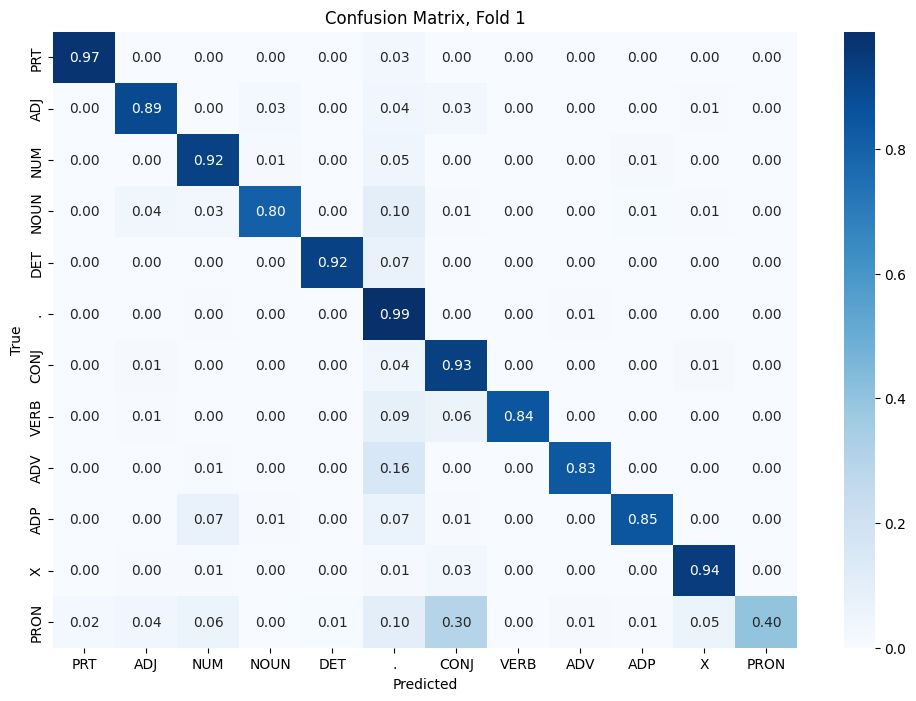

Evaluating Sentences: 100%|██████████████████████████████████| 11468/11468 [00:31<00:00, 365.36it/s]



----------------------------------------

Tag Wise Metrics for Fold 2:


Tag,Precision,Recall,F1
PRT,0.991413,0.967766,0.979447
ADJ,0.913893,0.895831,0.904772
NUM,0.952523,0.922960,0.937509
NOUN,0.910189,0.811910,0.858245
DET,0.994482,0.930314,0.961328
.,0.742699,0.988049,0.847984
CONJ,0.960275,0.929050,0.944404
VERB,0.976209,0.847153,0.907114
ADV,0.957477,0.828716,0.888455
ADP,0.902047,0.838600,0.869167



Overall Metrics for Fold 2:

F_0.5 Score : 0.912
F1 Score    : 0.892
F2 Score    : 0.876
Precision   : 0.929
Recall      : 0.868



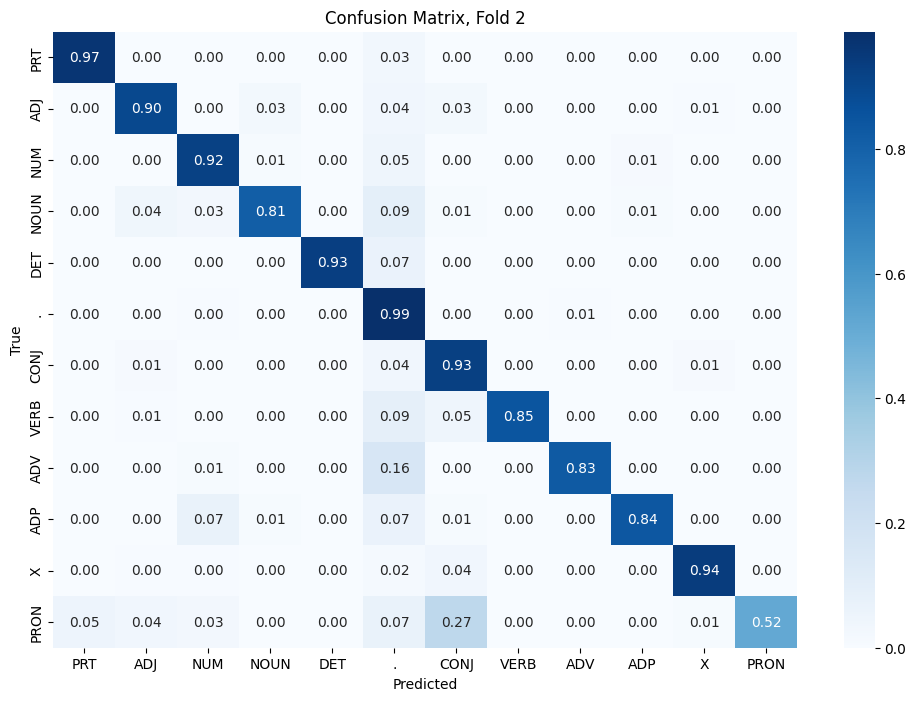

Evaluating Sentences: 100%|██████████████████████████████████| 11468/11468 [00:30<00:00, 379.70it/s]



----------------------------------------

Tag Wise Metrics for Fold 3:


Tag,Precision,Recall,F1
PRT,0.991632,0.969359,0.980369
ADJ,0.919029,0.892359,0.905498
NUM,0.949300,0.919810,0.934323
NOUN,0.906913,0.809326,0.855345
DET,0.993422,0.935918,0.963813
.,0.739423,0.986197,0.845165
CONJ,0.959205,0.930393,0.944579
VERB,0.976841,0.851141,0.909669
ADV,0.956891,0.826541,0.886953
ADP,0.908786,0.831541,0.868449



Overall Metrics for Fold 3:

F_0.5 Score : 0.906
F1 Score    : 0.887
F2 Score    : 0.872
Precision   : 0.922
Recall      : 0.864



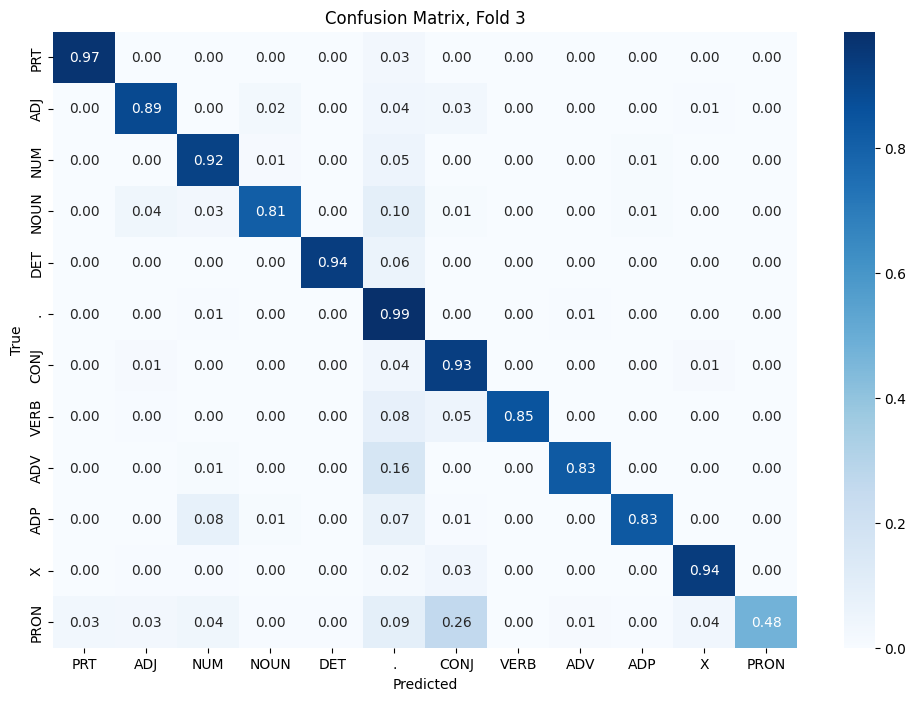

Evaluating Sentences: 100%|██████████████████████████████████| 11468/11468 [00:28<00:00, 399.37it/s]



----------------------------------------

Tag Wise Metrics for Fold 4:


Tag,Precision,Recall,F1
PRT,0.990904,0.968163,0.979401
ADJ,0.919177,0.896723,0.907811
NUM,0.948608,0.920774,0.934484
NOUN,0.907627,0.807665,0.854733
DET,0.992335,0.928790,0.959511
.,0.739659,0.988399,0.846127
CONJ,0.959912,0.927301,0.943325
VERB,0.971716,0.861264,0.913162
ADV,0.959027,0.827732,0.888556
ADP,0.905107,0.830095,0.865979



Overall Metrics for Fold 4:

F_0.5 Score : 0.908
F1 Score    : 0.890
F2 Score    : 0.876
Precision   : 0.922
Recall      : 0.868



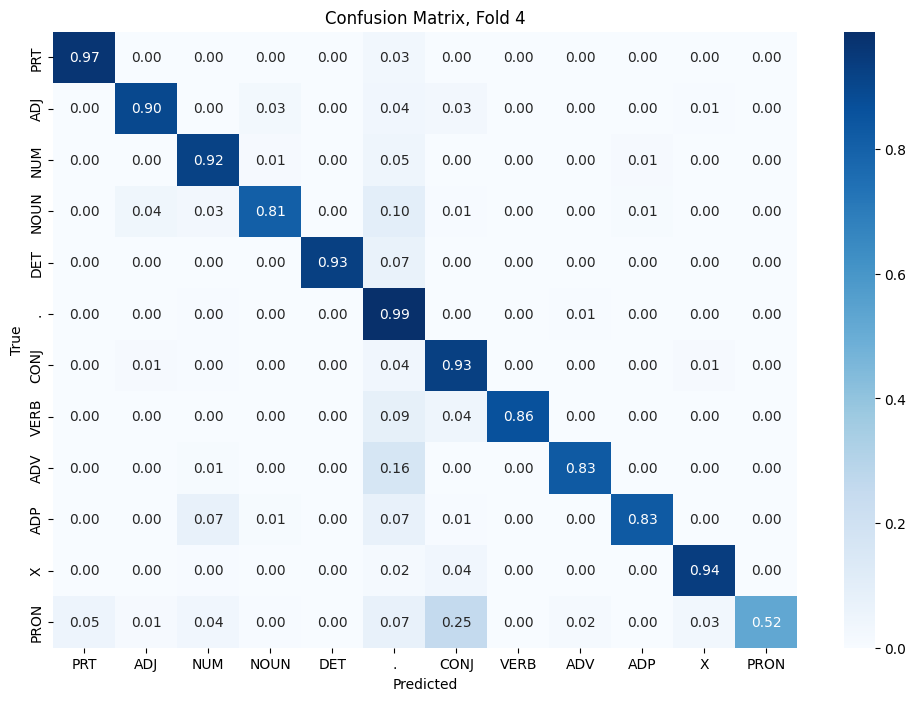

Evaluating Sentences: 100%|██████████████████████████████████| 11468/11468 [00:30<00:00, 382.20it/s]



----------------------------------------

Tag Wise Metrics for Fold 5:


Tag,Precision,Recall,F1
PRT,0.991961,0.975191,0.983505
ADJ,0.913953,0.898839,0.906333
NUM,0.948238,0.920678,0.934255
NOUN,0.910436,0.804077,0.853958
DET,0.993831,0.934038,0.963007
.,0.748438,0.987438,0.851485
CONJ,0.959627,0.930883,0.945036
VERB,0.975197,0.857851,0.912768
ADV,0.961179,0.830105,0.890847
ADP,0.905545,0.833655,0.868114



Overall Metrics for Fold 5:

F_0.5 Score : 0.909
F1 Score    : 0.892
F2 Score    : 0.878
Precision   : 0.923
Recall      : 0.870



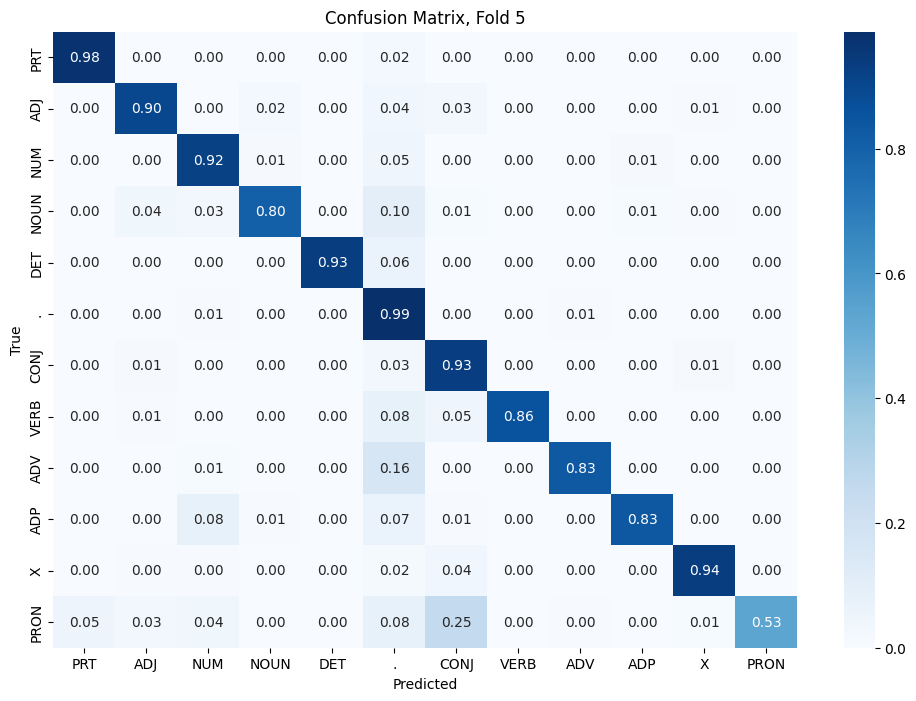


Average Metrics for all folds: 

Average F_0.5 Score : 0.908
Average F1 Score    : 0.889
Average F2 Score    : 0.874
Average Precision   : 0.924
Average Recall      : 0.866


In [ ]:
precision_sum = 0
recall_sum = 0
f05_score_sum = 0
f1_score_sum = 0
f2_score_sum = 0
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
for train_idx, test_idx in kf.split(corpus):
    train_data = [corpus[i] for i in train_idx]
    test_data = [corpus[i] for i in test_idx]

    # Initialising Model
    model = HMM(train_data, test_data)

    # Training step
    model.train()

    # Evaluation step
    model.evaluate()

    # Computing Metrics
    model.compute_metrics()

    # Print the results for each fold
    model.print_metrics(fold)
    # print(f"Fold Accuracy: {model.overall_accuracy}")

    # Updating sums
    precision_sum += model.overall_precision
    recall_sum += model.overall_recall
    f05_score_sum += model.f05
    f1_score_sum += model.f1
    f2_score_sum += model.f2

    fold += 1

print_overall_metrics(
    f05_score_sum, f1_score_sum, f2_score_sum, precision_sum, recall_sum, fold - 1
)

# 5. Data Preprocessing for POS Tagging

In [ ]:
def preprocess(text):
  # Tokenize the sentence using NLTK's word_tokenize function
  tokens = word_tokenize(text)
  print(tokens)

  # Print the tokens
  return tokens

sentence_to_tag = "This is CS626 Assignment-2. Its very easy to do"
print(model.predict(preprocess(sentence_to_tag)))

['This', 'is', 'CS626', 'Assignment-2', '.', 'Its', 'very', 'easy', 'to', 'do']
['DET', 'VERB', 'NOUN', 'NOUN', '.', 'DET', 'ADV', 'ADJ', 'PRT', 'VERB']


# 6. GUI (Gradio)

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

def text_analysis(text):
    tags = model.predict(preprocess(text))

    doc=[]
    j=0
    for i in word_tokenize(text):
      doc.append({"text":i,"pos_":tags[j]})
      j+=1
    pos_tokens = []
    pos_count = {
        "char_count": len(text),
        "token_count": j,
    }

    for token in doc:
        pos_tokens.extend([(token["text"], token["pos_"]), (" ", None)])

    return pos_tokens, pos_count

# print(text_analysis("THis is a test sentence"))


examples = [
    "Does Chicago have any stores and does Joe live here?",
    "This is CS626 Assignment-2. Its very easy to do"
]

# Create the Gradio interface
demo = gr.Interface(
    text_analysis,
    gr.Textbox(placeholder="Enter sentence here..."),
    ["highlight", "json"],
    examples=examples,
)


demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e18d679701dbbc3fc5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
#demo.close()